Enter the number of the star: 43
39429.14427012319 890.8112563703401
15.0852069987 pix
9.7261311865 pix
13.213320017420145 0.03653537473669125
5870.926365949069 129.2110789320561


Text(0,0.5,'Counts (DN/s)')

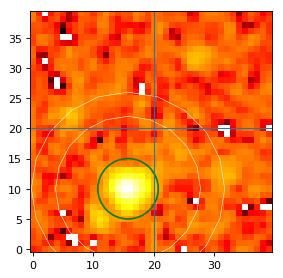

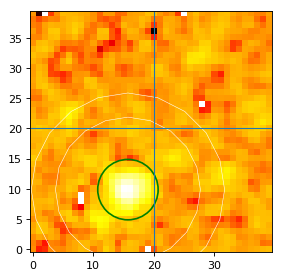

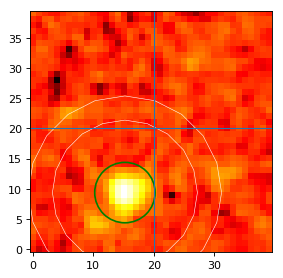

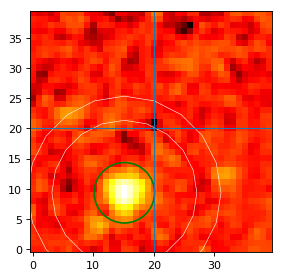

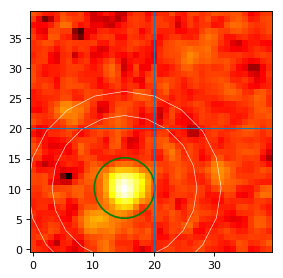

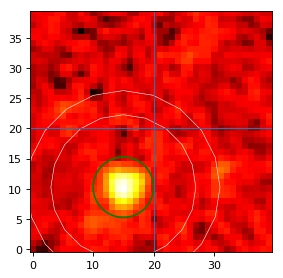

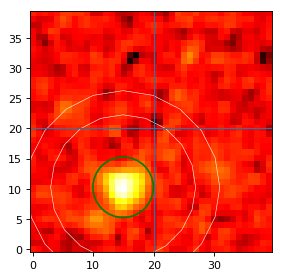

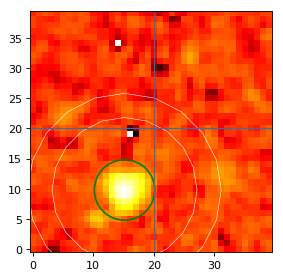

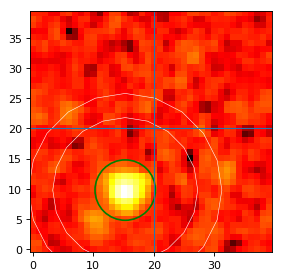

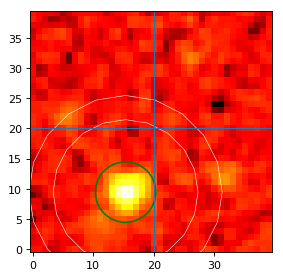

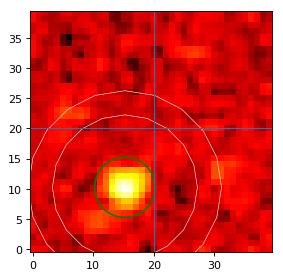

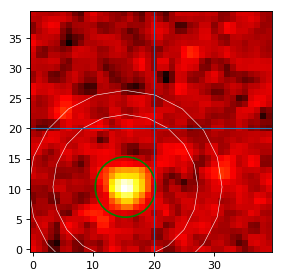

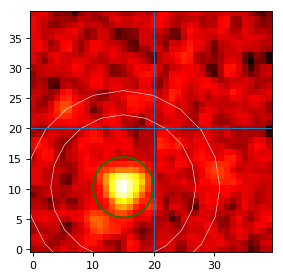

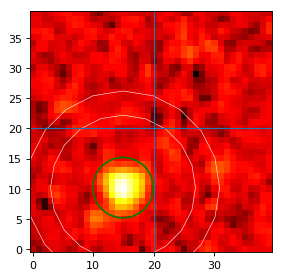

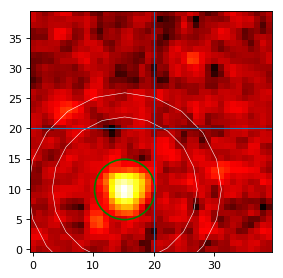

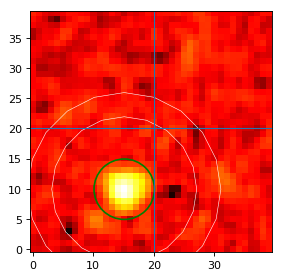

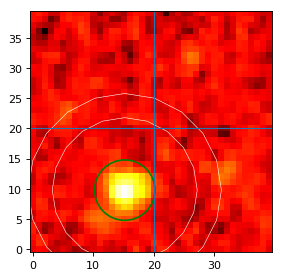

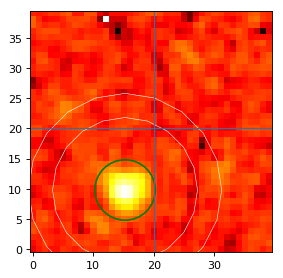

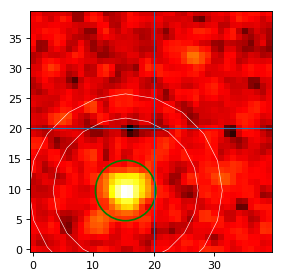

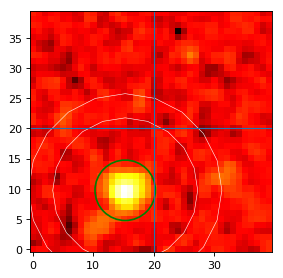

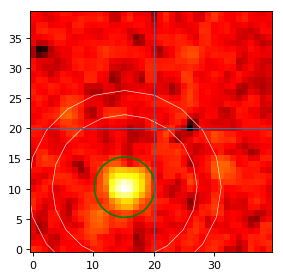

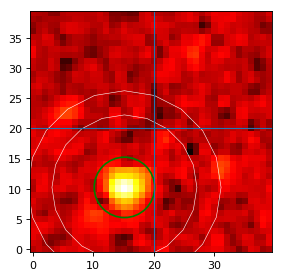

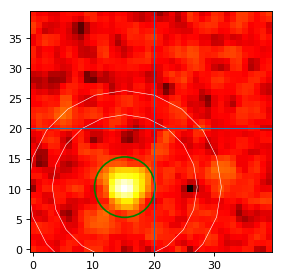

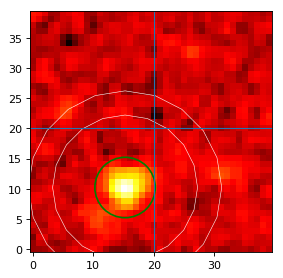

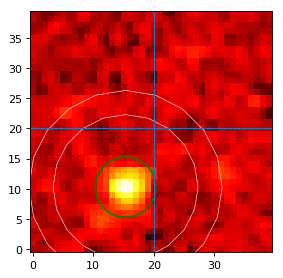

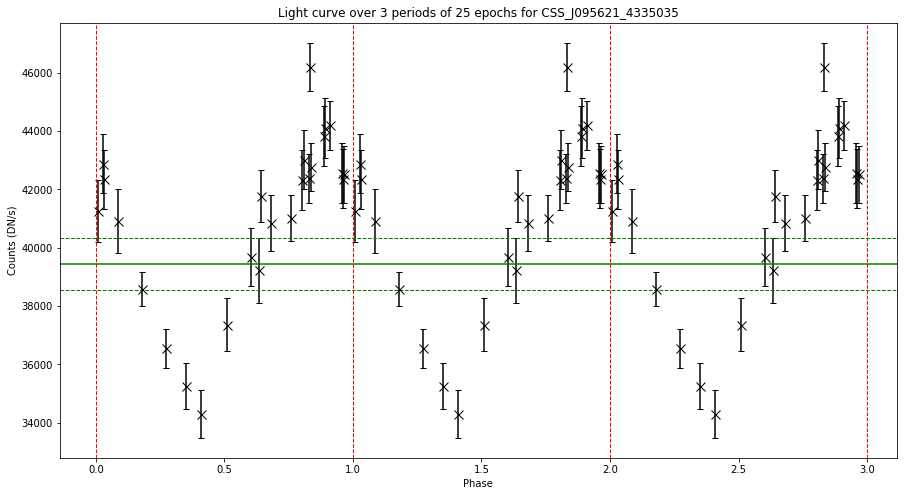

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy import wcs
from astropy.stats import mad_std
from astropy.time import Time
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from scipy import optimize
from photutils import aperture_photometry,CircularAperture,CircularAnnulus,IRAFStarFinder,SkyCircularAperture,DAOStarFinder
LC=[]

RR = int(input('Enter the number of the star: '))
index = RR-1
basedir = '/mnt/amw58-XDrive/Physics/ResearchProjects/VScowcroft/MPhys/MW_Mass/Sgr_Stream_Output/'
sheetname = '/u/m/amw58/dos/MPHYS_PROJECT/megasheet.csv'
sheet = np.genfromtxt(sheetname,skip_header=1,delimiter=',',dtype=None,unpack=True,encoding=None)
RA = sheet[index][9];dec = sheet[index][11]
CSSno = sheet[index][1]
P = sheet[index][20]
region_r = 20

detection_w = 5.   
aperture_r = 5.
r_in = 12.
r_out = 16.

if RR==43:
    nepochs = 25
elif RR==22:
    nepochs = 18
elif RR==59:
    nepochs = 9
elif RR==90:
    nepochs = 11
else:
    nepochs = 12

for i in range(nepochs):
    epoch=str(i+1)
    CSSep = CSSno + '__e' + epoch
    filename = basedir + CSSep + '/' + CSSep + '_3p6um.fits'
    
    fitsimg = fits.open(filename)
    header = fitsimg[0].header
    conv = header['GAIN']*header['EXPTIME']/header['FLUXCONV']   # conversion from Spitzer flux to counts
    data = fitsimg[0].data*conv
    
    th = header['CROTA2']*np.pi/180
    d_RA = RA - header['CRVAL1']
    d_dec = dec - header['CRVAL2']
    dX = -(d_RA*np.cos(th) + d_dec*np.sin(th))*6000
    dY = -(d_RA*np.sin(th) - d_dec*np.cos(th))*6000   
    Xstar = int(np.floor(dX + header['CRPIX1']))
    Ystar = int(np.floor(dY + header['CRPIX2']))
    region = data[Ystar-region_r:Ystar+region_r,Xstar-region_r:Xstar+region_r]
    
    bkg_sigma = mad_std(region,ignore_nan=True)
    bkg_median = np.nanmedian(region)
    starfind = IRAFStarFinder(fwhm=detection_w,threshold=10.*bkg_sigma,exclude_border=False,sharplo=0,roundhi=10,minsep_fwhm=0.)
    sources = starfind(region-bkg_median) 
    
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=aperture_r)
    annuli = CircularAnnulus(positions,r_in=r_in,r_out=r_out)
    totals = [apertures,annuli]
    phot_table = aperture_photometry(region, totals)
    Non = apertures.area()
    Nsky = annuli.area()
    
    bkg_mean = (phot_table['aperture_sum_1'])/annuli.area()
    bkg_sum = bkg_mean*apertures.area()
    final_sum = phot_table['aperture_sum_0']-bkg_sum
    phot_table['final_sum']=final_sum
    phot_table['weightedcounts'] = phot_table['final_sum']/np.sqrt((phot_table['xcenter']-region_r*u.pix)**2+(phot_table['ycenter']-region_r*u.pix)**2)
    counts = phot_table[phot_table['weightedcounts'].argmax()]['final_sum']
    JD = Time(header['DATE_OBS'], format='isot',scale='utc').jd
    MJD = JD - 2400000.5
    phase = MJD/P - np.floor(MJD/P)
    anerr = bkg_mean*Non/np.sqrt(Nsky)
    aperr = bkg_mean*np.sqrt(Non)
    poissonerr = np.sqrt(final_sum)
    countserrs = np.sqrt(anerr**2+aperr**2+poissonerr**2) 
    phot_table['err'] = countserrs
    countserr = phot_table[phot_table['weightedcounts'].argmax()]['err']
    LC.append([phase,counts,countserr])
    
    plt.figure(figsize=(4,4),dpi=80)
    plt.imshow(region,cmap='hot',origin='left',aspect='equal',norm=LogNorm())
    plt.axvline(region_r,lw=1);plt.axhline(region_r,lw=1)
    apertures.plot(color='green',lw=1.5,alpha=1)
    annuli.plot(color='white',lw=.5,alpha=1)
    
mosaic_filename = basedir + 'MegaMosaics/' + CSSno + '/' + CSSno + '_3p6um.fits'

fitsimg = fits.open(mosaic_filename)
header = fitsimg[0].header
conv = header['GAIN']*(header['MEAN_EXP']/28)/header['FLUXCONV']   # conversion from Spitzer flux to counts
data = fitsimg[0].data*conv

th = header['CROTA2']*np.pi/180
d_RA = RA - header['CRVAL1']
d_dec = dec - header['CRVAL2']
dX = -(d_RA*np.cos(th) + d_dec*np.sin(th))*6000
dY = -(d_RA*np.sin(th) - d_dec*np.cos(th))*6000   
Xstar = int(np.floor(dX + header['CRPIX1']))
Ystar = int(np.floor(dY + header['CRPIX2']))
region = data[Ystar-region_r:Ystar+region_r,Xstar-region_r:Xstar+region_r]

bkg_sigma = mad_std(region,ignore_nan=True)
bkg_median = np.nanmedian(region)
starfind = IRAFStarFinder(fwhm=detection_w,threshold=40.*bkg_sigma,exclude_border=False,sharplo=0,roundhi=10,minsep_fwhm=0.)
sources = starfind(region-bkg_median)

positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=aperture_r)
annuli = CircularAnnulus(positions,r_in=r_in,r_out=r_out)
totals = [apertures,annuli]
phot_table = aperture_photometry(region, totals)
Non = apertures.area()
Nsky = annuli.area()

bkg_mean = (phot_table['aperture_sum_1'])/annuli.area()
bkg_sum = bkg_mean*apertures.area()
final_sum = phot_table['aperture_sum_0']-bkg_sum
phot_table['final_sum']=final_sum
phot_table['weightedcounts'] = phot_table['final_sum']/np.sqrt((phot_table['xcenter']-region_r*u.pix)**2+(phot_table['ycenter']-region_r*u.pix)**2)
bigcounts = phot_table[phot_table['weightedcounts'].argmax()]['final_sum']
anerr = bkg_mean*Non/np.sqrt(Nsky)
aperr = bkg_mean*np.sqrt(Non)
poissonerr = np.sqrt(final_sum)
countserrs = np.sqrt(anerr**2+aperr**2+poissonerr**2) 
phot_table['err'] = countserrs
bigcountserr = phot_table[phot_table['weightedcounts'].argmax()]['err']
print bigcounts,bigcountserr
print phot_table[phot_table['weightedcounts'].argmax()]['xcenter']
print phot_table[phot_table['weightedcounts'].argmax()]['ycenter']

def func(x):
    return (-2.5/np.log(10))/x

k = 0.1088; kerr = 0.0022
F0 = 280.9; F0err = 4.1
s_ang = np.pi*(aperture_r*0.6*np.pi/(180*3600))**2
m = -2.5*np.log10(k*bigcounts*s_ang*1000000/(F0))
merr = np.sqrt(((F0err**2)*func(F0)**2)+((bigcountserr**2)*func(bigcounts)**2)+((kerr**2)*func(k)**2))
print m,merr

a = -0.44; aerr = 0.02
b = -3.58; berr = 0.33
M = a+b*(np.log10(P)+0.27)
Merr2 = (aerr)**2+((berr**2)*(np.log10(P)+0.27)**2)+(0.01*b/np.log(10))**2
muerr2 = Merr2+merr**2
d = 10**(((m-M)/5)+1)
derr = np.sqrt(muerr2*(d*np.log(10)/5)**2)
print d,derr
#print CSSno

LC.sort()
phases = []
counts = []
errors = []
nperiods = 3
for i in range(nepochs*nperiods):
    phases.append(LC[np.mod(i,nepochs)][0]+np.floor(i/nepochs))
    counts.append(LC[np.mod(i,nepochs)][1])
    errors.append(LC[np.mod(i,nepochs)][2])
magnitudes = np.zeros(len(counts))
magerrors = np.zeros(len(counts))
for i in range(len(counts)):
    magnitudes[i] = 25-2.5*np.log10(counts[i])
    magerrors[i] = (errors[i]/counts[i])*2.5/np.log(10)
    
#def sine_fit(x,a,b,c):
#    return -a*np.sin(2*np.pi*x+b)+c
#params,params_covariance = optimize.curve_fit(sine_fit,phases,fluxes)
#print params,params_covariance
#fit_x = np.linspace(0.0,3.0,121)
#flux_fit=[]
#for i in range(len(fit_x)):
#    flux_fit.append(sine_fit(fit_x[i],params[0],params[1],params[2]))

graphtitle = 'Light curve over ' + '{0}'.format(nperiods) + ' periods of ' + '{0}'.format(nepochs) + ' epochs for ' + '{0}'.format(CSSno)
plt.figure(figsize=(15,8))
plt.title(graphtitle)
plt.errorbar(phases,counts,yerr=errors, fmt='x',color='black',capsize=3,markersize=9)
#plt.plot(fit_x,flux_fit)
for i in range(nperiods+1):
    plt.axvline(i,color='r',linestyle='--',lw=1)
plt.axhline(bigcounts,color='green')
#plt.axhline(params[2],color='blue')
plt.axhline(bigcounts+bigcountserr,color='green',linestyle='--',lw=1)
plt.axhline(bigcounts-bigcountserr,color='green',linestyle='--',lw=1)
plt.xlabel('Phase')
plt.ylabel('Counts (DN/s)')

In [34]:
print header

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel- floating point                 NAXIS   =                    2 / STANDARD FITS FORMAT                           NAXIS1  =                  606 /  Axis Length                                   NAXIS2  =                  691 /  Axis Length                                   TELESCOP= 'Spitzer '           / SPITZER Space Telescope                        INSTRUME= 'IRAC    '           / SPITZER Space Telescope instrument ID          CHNLNUM =                    1 / 1 digit instrument channel number              EXPTYPE = 'sci     '           / Exposure Type                                  FOVID   =                   67 / Field of View ID                               FOVNAME = 'IRAC_Center_of_3.6&5.8umArray' / Field of View Name                  PRODTYPE= 'IMAGE   '           / type of this data                              OBSRVR  = 'Kathryn Johnston'   / Observe

 [astropy.io.fits.verify]


In [1]:
np.log(10)

NameError: name 'np' is not defined